### Deep Learning for Images with PyTorch

#### Images
Images consist of pixels, each of which contains color information (ints from 0 - 255; one channel if grayscale and three if RGB).

#### Loading images to PyTorch
Use `ImageFolder` from `torchvision` to create a `Dataset` of images from a dataset on disk, or download a sample one such as `MNIST` from `torchvision`.

#### Transformation argument
Use `Compose()` and the assortment of transformation options from `torchvision.transforms` to pack image transformations into an argument passed to dataset preprocessing / data augmentation.

torch.Size([1, 1, 128, 128])
torch.Size([128, 128])


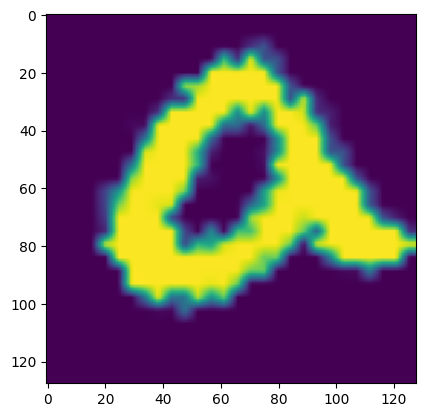

In [ ]:
import torch
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder
from torchvision.datasets import MNIST
from torchvision import transforms

train_transforms = transforms.Compose([
    # Data augmentation: random transformations to original images generate more data
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),

    transforms.ToTensor(), # parse to tensor
    transforms.Resize((128, 128)) # resize to 128x128px
])

# dataset_train = ImageFolder("data/clouds_train", transform=train_transforms)
dataset_train = MNIST("data/mnist", transform=train_transforms, download=True) # download the MNIST dataset
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)

image, label = next(iter(dataloader_train))
print(image.shape)

image = image.permute(1, 2, 3, 0).squeeze()
print(image.shape)

# @@@ Displaying an Image @@@
import matplotlib.pyplot as plt

plt.imshow(image)
plt.show()

#### Convolutional Neural Networks (CNNs)

